In [1]:
# train_modelnet10_umc_demo.py
"""
Train ModelNet10 twice:
  1) weights ENABLED (learn w with orthogonality regularizer using Fix 1b: correlation-normalized Gram)
  2) weights DISABLED baseline (w ≡ 1)

Prints:
- train/test accuracy
- orthogonality metric (corr-normalized)
- weight stats (min/mean/max/ESS)
- end-of-run detailed metrics on an example graph, including:
    raw Gram error vs corr-normalized Gram error
    correlations with degree and mean kNN distance (for the weights-enabled model)
"""

import os
import time
import copy

import torch
import torch.nn.functional as F
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, SamplePoints, NormalizeScale, KNNGraph

from umc_modelnet10_utils import (
    seed_everything,
    MakeUndirected,
    ComputePhiRWFromSym,
    FixedDegreeClassifier,
    UMCClassifier,
    NoWeightClassifier,
    orthogonality_loss,
    RandomIrregularResample,
    batch_weight_stats,
    IrregularResample,
    gram_error,
    corr_gram_error,
    pearson_corr,
)

from torch_geometric.utils import degree
from torch_scatter import scatter_mean


def make_loaders(train_ds, test_ds, batch_size: int, seed: int):
    g = torch.Generator()
    g.manual_seed(seed)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, test_loader


@torch.no_grad()
def eval_epoch(model, test_loader, K: int, ortho_mode: str):
    model.eval()
    correct = 0
    total = 0
    ortho_accum = 0.0
    wstats_accum = None
    batches = 0

    for data in test_loader:
        data = data.to(next(model.parameters()).device)
        logp, w, aux = model(data)
        pred = logp.argmax(dim=1)
        correct += int((pred == data.y).sum().item())
        total += int(data.y.numel())

        o = float(orthogonality_loss(data.phi, w, B=aux["B"], N=aux["N"], K=K, mode=ortho_mode).item())
        ortho_accum += o

        stats = batch_weight_stats(w, B=aux["B"], N=aux["N"])
        if wstats_accum is None:
            wstats_accum = {k: float(v.item()) for k, v in stats.items()}
        else:
            for k in wstats_accum:
                wstats_accum[k] += float(stats[k].item())

        batches += 1

    acc = correct / max(total, 1)
    ortho_mean = ortho_accum / max(batches, 1)
    for k in wstats_accum:
        wstats_accum[k] /= max(batches, 1)
    return acc, ortho_mean, wstats_accum


def train_run(
    run_name: str,
    model,
    train_loader,
    test_loader,
    K: int,
    epochs: int,
    lr: float,
    lambda_ortho: float,
    lambda_w_reg: float,
    ortho_mode: str = "corr",
    include_ortho_in_loss: bool = True,
):
    device = next(model.parameters()).device
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_test_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        t0 = time.time()

        correct = 0
        total = 0

        loss_accum = 0.0
        cls_accum = 0.0
        ortho_accum = 0.0
        batches = 0

        for data in train_loader:
            data = data.to(device)
            logp, w, aux = model(data)

            cls_loss = F.nll_loss(logp, data.y)
            ortho_val = orthogonality_loss(data.phi, w, B=aux["B"], N=aux["N"], K=K, mode=ortho_mode)
            w_reg = (w - 1.0).pow(2).mean()

            if include_ortho_in_loss:
                loss = cls_loss + lambda_ortho * ortho_val + lambda_w_reg * w_reg
            else:
                # baseline: w is constant, ortho has no gradients anyway; keep loss meaningful
                loss = cls_loss

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            pred = logp.argmax(dim=1)
            correct += int((pred == data.y).sum().item())
            total += int(data.y.numel())

            loss_accum += float(loss.item())
            cls_accum += float(cls_loss.item())
            ortho_accum += float(ortho_val.item())
            batches += 1

        train_acc = correct / max(total, 1)
        train_loss = loss_accum / max(batches, 1)
        train_cls = cls_accum / max(batches, 1)
        train_ortho = ortho_accum / max(batches, 1)

        test_acc, test_ortho, wstats = eval_epoch(model, test_loader, K=K, ortho_mode=ortho_mode)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_state = copy.deepcopy(model.state_dict())

        dt = time.time() - t0
        print(
            f"[{run_name}] Epoch {epoch:02d} | "
            f"train_loss {train_loss:.4f} (cls {train_cls:.4f}, ortho {train_ortho:.2e}) | "
            f"train_acc {train_acc*100:.2f}% | test_acc {test_acc*100:.2f}% | "
            f"test_ortho {test_ortho:.2e} | "
            f"w_mean {wstats['w_mean']:.3f} w_min {wstats['w_min']:.3f} w_max {wstats['w_max']:.3f} "
            f"ess_frac {wstats['ess_frac']:.3f} | {dt:.1f}s"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"\n[{run_name}] Best test_acc: {best_test_acc*100:.2f}% (restored best checkpoint)\n")
    return best_test_acc


@torch.no_grad()
def inspect_one_example(run_name: str, model, test_loader, K: int):
    device = next(model.parameters()).device
    model.eval()

    data = next(iter(test_loader)).to(device)
    logp, w, aux = model(data)
    B, N = aux["B"], aux["N"]

    # take graph 0
    w0 = w.view(B, N)[0].detach().cpu()
    phi0 = data.phi.view(B, N, K)[0].detach()

    w_uniform = torch.ones_like(w0)

    err_uniform_raw = float(gram_error(phi0, w_uniform.to(phi0.device), K=K).item())
    err_learned_raw = float(gram_error(phi0, w0.to(phi0.device), K=K).item())

    err_uniform_corr = float(corr_gram_error(phi0, w_uniform.to(phi0.device), K=K).item())
    err_learned_corr = float(corr_gram_error(phi0, w0.to(phi0.device), K=K).item())

    print(f"=== [{run_name}] Example graph 0 ===")
    print("w stats: min {:.4f} mean {:.4f} max {:.4f} max/min {:.4f}".format(
        float(w0.min()), float(w0.mean()), float(w0.max()), float(w0.max() / (w0.min() + 1e-12))
    ))
    ess = float((w0.sum()**2) / (w0.pow(2).sum() + 1e-12))
    print(f"ESS: {ess:.1f} / {N} (ESS/N = {ess/N:.3f})")

    print("\nRaw Gram error  ||Phi^T diag(w) Phi - I||_F^2")
    print(f"  uniform: {err_uniform_raw:.6f}")
    print(f"  learned: {err_learned_raw:.6f}")

    print("\nCorr Gram error ||C(w) - I||_F^2   (Fix 1b metric)")
    print(f"  uniform: {err_uniform_corr:.6f}")
    print(f"  learned: {err_learned_corr:.6f}")

    # density proxies for graph 0
    # deg was stored by pre_transform as data.deg (per-node)
    deg_all = getattr(data, "deg", None)
    if deg_all is not None:
        deg0 = deg_all.view(B, N)[0].detach().cpu()
    else:
        # fallback: compute from edges
        row = data.edge_index[0]
        deg0 = degree(row, num_nodes=data.num_nodes, dtype=data.pos.dtype).view(B, N)[0].detach().cpu()

    # mean knn distance proxy
    row, col = data.edge_index[0], data.edge_index[1]
    dist = (data.pos[row] - data.pos[col]).norm(dim=1)
    mean_dist_all = scatter_mean(dist, row, dim=0, dim_size=data.num_nodes)
    mean_dist0 = mean_dist_all.view(B, N)[0].detach().cpu()

    print("\nCorrelations with density proxies (graph 0)")
    print(f"corr(w, deg):        {float(pearson_corr(w0, deg0).item()):+.3f}")
    print(f"corr(w, 1/deg):      {float(pearson_corr(w0, 1.0/(deg0+1e-6)).item()):+.3f}")
    print(f"corr(w, meanDist):   {float(pearson_corr(w0, mean_dist0).item()):+.3f}")
    print(f"corr(w, 1/meanDist): {float(pearson_corr(w0, 1.0/(mean_dist0+1e-6)).item()):+.3f}")

    print("\nFirst 30 weights:", w0[:30].tolist())
    print("-" * 60)


# ---------------------------------------------------

seed_everything(5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# Hyperparameters
# ----------------------------
num_points = 512
K = 64
knn_k = 20
batch_size = 16
epochs = 30
lr = 1e-3
max_bias = 3.0

lambda_ortho = 0.0
lambda_w_reg = 0.00   # Prevent extreme weights

ortho_mode = "corr"

root = os.path.expanduser("../data/ModelNet_UMC")

pre_transform_dense = Compose([
    SamplePoints(2048),  # Sample dense cloud from mesh
    NormalizeScale(),    # Center and scale
])

# Dynamic Augmentation
train_transform = Compose([
    RandomIrregularResample(num_points=512, max_bias=max_bias),
    NormalizeScale(),
    KNNGraph(k=knn_k),
    MakeUndirected(),
    ComputePhiRWFromSym(K=K, store_aux=True),
])

# Standard Uniform Sampling
# Takes the 2048 points -> Uniformly samples 512 -> Rebuilds Graph
test_transform = Compose([
    # Downsample uniformly 2048->512
    IrregularResample(num_points=512, bias_strength=0.0), 
    NormalizeScale(),
    KNNGraph(k=knn_k),
    MakeUndirected(),
    ComputePhiRWFromSym(K=K, store_aux=True),
])

print("Reloading dataset with Dense Cache (2048 points)...")

train_ds = ModelNet(root=root, name='10', train=True, 
                    pre_transform=pre_transform_dense, 
                    transform=train_transform, 
                    force_reload=True)

test_ds  = ModelNet(root=root, name='10', train=False, 
                    pre_transform=pre_transform_dense, 
                    transform=test_transform, 
                    force_reload=True)

print(f"Dataset reloaded. Training samples: {len(train_ds)}")

# ----------------------------
# Run 1: weights enabled
# ----------------------------
train_loader, test_loader = make_loaders(train_ds, test_ds, batch_size=batch_size, seed=0)

model_w = UMCClassifier(
    K=K,
    num_classes=10,
    in_channels=3,
    use_pos=True,
    use_density=True,
).to(device)

best_w = train_run(
    run_name="WEIGHTS_ON",
    model=model_w,
    train_loader=train_loader,
    test_loader=test_loader,
    K=K,
    epochs=epochs,
    lr=lr,
    lambda_ortho=lambda_ortho,
    lambda_w_reg=lambda_w_reg,
    ortho_mode=ortho_mode,
    include_ortho_in_loss=True,
)
inspect_one_example("WEIGHTS_ON", model_w, test_loader, K=K)

# ----------------------------
# Run 2: weights disabled baseline
# ----------------------------
# Recreate loaders with same seed so shuffling matches as closely as possible.
train_loader2, test_loader2 = make_loaders(train_ds, test_ds, batch_size=batch_size, seed=0)

model_nw = NoWeightClassifier(
    K=K,
    num_classes=10,
    in_channels=3,
).to(device)

best_nw = train_run(
    run_name="WEIGHTS_OFF",
    model=model_nw,
    train_loader=train_loader2,
    test_loader=test_loader2,
    K=K,
    epochs=epochs,
    lr=lr,
    lambda_ortho=lambda_ortho,
    lambda_w_reg=lambda_w_reg,
    ortho_mode=ortho_mode,
    include_ortho_in_loss=False,  # ortho has no gradients anyway; keep baseline clean
)
inspect_one_example("WEIGHTS_OFF", model_nw, test_loader2, K=K)

print("\n=== Summary ===")
print(f"Best test acc (weights ON):  {best_w*100:.2f}%")
print(f"Best test acc (weights OFF): {best_nw*100:.2f}%")
print("Done.")

Device: cuda
Reloading dataset with Dense Cache (2048 points)...


Processing...
Done!
Processing...
Done!


Dataset reloaded. Training samples: 3991
[WEIGHTS_ON] Epoch 01 | train_loss 1.1688 (cls 1.1688, ortho 4.55e-04) | train_acc 59.66% | test_acc 63.99% | test_ortho 3.11e-04 | w_mean 1.000 w_min 0.732 w_max 1.536 ess_frac 0.980 | 29.1s
[WEIGHTS_ON] Epoch 02 | train_loss 1.0084 (cls 1.0084, ortho 6.10e-04) | train_acc 65.09% | test_acc 65.97% | test_ortho 4.44e-04 | w_mean 1.000 w_min 0.670 w_max 1.715 ess_frac 0.968 | 28.9s
[WEIGHTS_ON] Epoch 03 | train_loss 0.9293 (cls 0.9293, ortho 6.03e-04) | train_acc 67.82% | test_acc 68.83% | test_ortho 4.61e-04 | w_mean 1.000 w_min 0.668 w_max 1.666 ess_frac 0.968 | 28.5s
[WEIGHTS_ON] Epoch 04 | train_loss 0.9171 (cls 0.9171, ortho 6.41e-04) | train_acc 68.32% | test_acc 72.36% | test_ortho 3.53e-04 | w_mean 1.000 w_min 0.696 w_max 1.613 ess_frac 0.976 | 28.7s
[WEIGHTS_ON] Epoch 05 | train_loss 0.8771 (cls 0.8771, ortho 6.95e-04) | train_acc 69.25% | test_acc 71.70% | test_ortho 5.54e-04 | w_mean 1.000 w_min 0.616 w_max 1.654 ess_frac 0.959 | 28.6s

Training FixedDegreeClassifier baseline (for fair comparison)...
[FixedDegree] Epoch 1 Clean Acc: 67.29%
[FixedDegree] Epoch 2 Clean Acc: 65.97%
[FixedDegree] Epoch 3 Clean Acc: 67.73%
[FixedDegree] Epoch 4 Clean Acc: 68.39%
[FixedDegree] Epoch 5 Clean Acc: 72.14%
[FixedDegree] Epoch 6 Clean Acc: 71.37%
[FixedDegree] Epoch 7 Clean Acc: 69.27%
[FixedDegree] Epoch 8 Clean Acc: 73.35%
[FixedDegree] Epoch 9 Clean Acc: 74.34%
[FixedDegree] Epoch 10 Clean Acc: 75.44%
[FixedDegree] Epoch 11 Clean Acc: 75.77%
[FixedDegree] Epoch 12 Clean Acc: 71.92%
[FixedDegree] Epoch 13 Clean Acc: 75.88%
[FixedDegree] Epoch 14 Clean Acc: 71.59%
[FixedDegree] Epoch 15 Clean Acc: 75.88%
[FixedDegree] Epoch 16 Clean Acc: 74.78%
[FixedDegree] Epoch 17 Clean Acc: 73.13%
[FixedDegree] Epoch 18 Clean Acc: 77.20%
[FixedDegree] Epoch 19 Clean Acc: 77.09%
[FixedDegree] Epoch 20 Clean Acc: 77.31%
[FixedDegree] Epoch 21 Clean Acc: 75.66%
[FixedDegree] Epoch 22 Clean Acc: 75.88%
[FixedDegree] Epoch 23 Clean Acc: 76.43%
[

/home/zli/clique/.venv/lib/python3.12/site-packages/torch_geometric/data/dataset.py:115: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  self._process()


0.0    | 76.98    % | 77.09    % | 79.07    % | 
1.0    | 73.02    % | 73.02    % | 74.34    % | 
2.0    | 66.19    % | 66.63    % | 69.71    % | 
3.0    | 59.36    % | 59.91    % | 61.89    % | 
4.0    | 47.47    % | 50.00    % | 53.30    % | 


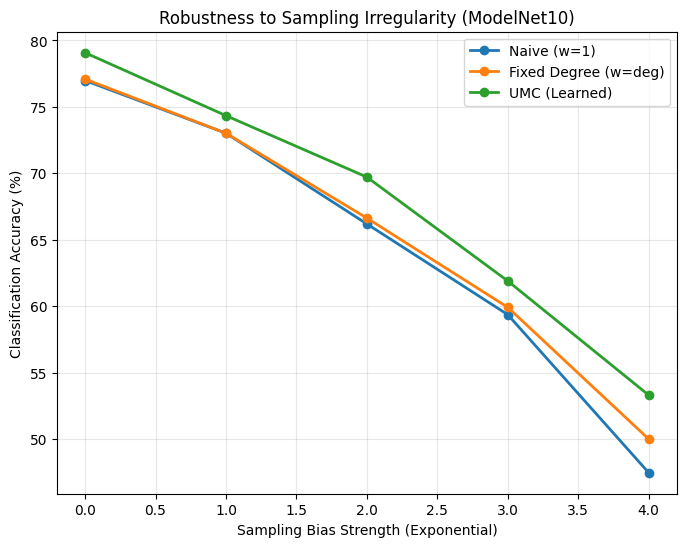

In [2]:
# ---------------------------------------------------------
# CELL: ROBUSTNESS / RESAMPLING STRESS TEST
# ---------------------------------------------------------

import torch
import torch.nn.functional as F
from torch_geometric.transforms import BaseTransform, Compose, NormalizeScale, KNNGraph
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import ModelNet
import pandas as pd

# Reuse utilities from previous cells
from umc_modelnet10_utils import (
    MakeUndirected, 
    ComputePhiRWFromSym, 
    batch_weight_stats, 
    seed_everything,
    IrregularResample
)

# ---------------------------------------------------------
# 1. Train the FixedDegree Baseline (Quickly)
# ---------------------------------------------------------
print("Training FixedDegreeClassifier baseline (for fair comparison)...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K = 64
root = "../data/ModelNet_UMC" # Same root as before

train_loader, test_loader = make_loaders(train_ds, test_ds, batch_size=batch_size, seed=0)

model_fd = FixedDegreeClassifier(K=K, num_classes=10).to(device)
opt_fd = torch.optim.Adam(model_fd.parameters(), lr=1e-3)

# Quick training loop (10 epochs is enough for convergence on MN10)
for epoch in range(1, 31):
    model_fd.train()
    for data in train_loader:
        data = data.to(device)
        logp, _, _ = model_fd(data)
        loss = F.nll_loss(logp, data.y)
        opt_fd.zero_grad()
        loss.backward()
        opt_fd.step()
    
    # Quick eval
    model_fd.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            logp, _, _ = model_fd(data)
            correct += (logp.argmax(1) == data.y).sum().item()
            total += data.y.numel()
    print(f"[FixedDegree] Epoch {epoch} Clean Acc: {correct/total*100:.2f}%")

print("FixedDegree Baseline Trained.\n")

# ---------------------------------------------------------
# 3. Run the Stress Test Loop
# ---------------------------------------------------------

def evaluate_on_bias(model, bias_level):
    """
    Creates a fresh dataset with specific corruption bias, 
    recomputes graphs on the fly, and evaluates.
    """
    # Pipeline: Corrupt -> Normalize -> Rebuild Graph -> Recompute Basis
    stress_transform = Compose([
        IrregularResample(num_points=512, bias_strength=bias_level),
        NormalizeScale(),
        KNNGraph(k=20),
        MakeUndirected(),
        ComputePhiRWFromSym(K=64, store_aux=True)
    ])
    
    # We use 'transform' (applied on access) instead of 'pre_transform' (cached)
    # This ensures we generate corrupted samples on the fly.
    # Note: We use the raw test set.
    ds = ModelNet(root=root, name='10', train=False, transform=stress_transform)
    loader = DataLoader(ds, batch_size=16, shuffle=False)
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logp, _, _ = model(data)
            pred = logp.argmax(dim=1)
            correct += int((pred == data.y).sum().item())
            total += int(data.y.numel())
            
    return correct / total

# Define models to compare
# Assuming 'model_w' (UMC) and 'model_nw' (Naive) exist from previous cell
models = {
    "Naive (w=1)": model_nw,
    "Fixed Degree (w=deg)": model_fd,
    "UMC (Learned)": model_w
}

bias_levels = [0.0, 1.0, 2.0, 3.0, 4.0]
results = {name: [] for name in models.keys()}

print(f"{'Bias':<6} | {'Naive':<10} | {'FixedDeg':<10} | {'UMC':<10}")
print("-" * 45)

for bias in bias_levels:
    row_str = f"{bias:<6.1f} | "
    for name, model in models.items():
        acc = evaluate_on_bias(model, bias)
        results[name].append(acc * 100)
        row_str += f"{acc*100:<9.2f}% | "
    print(row_str)

# ---------------------------------------------------------
# 4. Visualization (Optional)
# ---------------------------------------------------------
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    for name, accs in results.items():
        plt.plot(bias_levels, accs, marker='o', label=name, linewidth=2)
    plt.title("Robustness to Sampling Irregularity (ModelNet10)")
    plt.xlabel("Sampling Bias Strength (Exponential)")
    plt.ylabel("Classification Accuracy (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except ImportError:
    pass